# **Import des librairies**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

In [ ]:
# version de tensorflow utilisée
import tensorflow.keras
print(tensorflow.__version__)

2.4.1


In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

# **1 - Préparation des données**

##Import data

In [ ]:
from google.colab import files
data_to_load = files.upload()

Saving credit_immobilier_ISF.csv to credit_immobilier_ISF (1).csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(data_to_load['credit_immobilier_ISF.csv']))

In [ ]:
df.head()

,compte_courant,duree_emprunt_mois,historique_credit,raison,montant,compte_epargne,duree_emploi,annees_presence_logement,age,autre_credit,logement,nbre_emprunts_actuels,job,dependants,telephone,defaillant,revenufinal
0,< 0 Euro,6,critique,ameublement,1169,inconnu,> 7 annees,4.0,67.0,aucun,proprietaire,2,qualifie,1,oui,non,8135.110140
1,1 - 200 Euro,48,bon,ameublement,5951,< 100 Euro,1 - 4 annees,2.0,22.0,aucun,proprietaire,1,qualifie,1,oui,oui,19334.307686
2,inconnu,12,critique,education,2096,< 100 Euro,4 - 7 annees,3.0,49.0,aucun,proprietaire,1,non_qualifie,2,oui,non,4864.954258
3,< 0 Euro,42,bon,ameublement,7882,< 100 Euro,4 - 7 annees,4.0,45.0,aucun,autre,1,qualifie,2,oui,non,22152.947349
4,< 0 Euro,24,pauvre,auto,4870,< 100 Euro,1 - 4 annees,4.0,53.0,aucun,autre,2,qualifie,2,oui,oui,23900.704144


In [ ]:
df.tail()

,compte_courant,duree_emprunt_mois,historique_credit,raison,montant,compte_epargne,duree_emploi,annees_presence_logement,age,autre_credit,logement,nbre_emprunts_actuels,job,dependants,telephone,defaillant,revenufinal
1016,inconnu,45,critique,auto,4576,100 - 500 Euro,chomeur,4.0,27.0,aucun,proprietaire,1,qualifie,1,oui,non,17281.972830
1017,1 - 200 Euro,45,critique,auto,4576,100 - 500 Euro,chomeur,4.0,27.0,aucun,proprietaire,1,qualifie,1,oui,non,23544.389153
1018,inconnu,15,critique,auto,5045,inconnu,> 7 annees,4.0,59.0,aucun,proprietaire,1,qualifie,1,oui,non,6247.903416
1019,1 - 200 Euro,15,tres bon,auto,1234,100 - 500 Euro,1 - 4 annees,2.0,25.0,aucun,locataire,1,qualifie,1,oui,oui,3702.608164
1020,1 - 200 Euro,35,bon,auto,1734,100 - 500 Euro,1 - 4 annees,2.0,25.0,aucun,proprietaire,1,qualifie,1,oui,oui,9141.314880


##Analyse de données

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   compte_courant            1021 non-null   object 
 1   duree_emprunt_mois        1021 non-null   int64  
 2   historique_credit         1021 non-null   object 
 3   raison                    1021 non-null   object 
 4   montant                   1021 non-null   int64  
 5   compte_epargne            1020 non-null   object 
 6   duree_emploi              1021 non-null   object 
 7   annees_presence_logement  1018 non-null   float64
 8   age                       1020 non-null   float64
 9   autre_credit              1021 non-null   object 
 10  logement                  1021 non-null   object 
 11  nbre_emprunts_actuels     1021 non-null   int64  
 12  job                       1018 non-null   object 
 13  dependants                1021 non-null   object 
 14  telephon

In [ ]:
# Quelles sont les colonnes catégorielles

df.select_dtypes(exclude=['int64', 'float']).columns

Index(['compte_courant', 'historique_credit', 'raison', 'compte_epargne',
       'duree_emploi', 'autre_credit', 'logement', 'job', 'dependants',
       'telephone', 'defaillant'],
      dtype='object')

Toutes les variables ont une signification, nous ne retirons aucune d'entre elles.

In [ ]:
# dimensions du data frame
df.shape

(1021, 17)

In [ ]:
# stats élémentaires
df.describe()

,duree_emprunt_mois,montant,annees_presence_logement,age,nbre_emprunts_actuels,revenufinal
count,1021.000000,1021.000000,1018.000000,1020.000000,1021.000000,1021.000000
mean,20.770813,3250.088149,2.844794,35.491176,1.409403,12273.073874
std,12.050318,2830.788792,1.104864,11.395078,0.576390,11200.509536
min,4.000000,250.000000,1.000000,19.000000,1.000000,734.476054
25%,12.000000,1352.000000,2.000000,27.000000,1.000000,5192.478646
50%,18.000000,2299.000000,3.000000,33.000000,1.000000,8615.582896
75%,24.000000,3966.000000,4.000000,42.000000,2.000000,15559.590686
max,72.000000,18424.000000,4.000000,75.000000,4.000000,79354.527366


In [ ]:
# répartition instances sur le label montant
df['montant'].value_counts()

975     6
1382    5
1169    4
368     4
4576    3
       ..
1343    1
7485    1
3345    1
1338    1
2051    1
Name: montant, Length: 926, dtype: int64

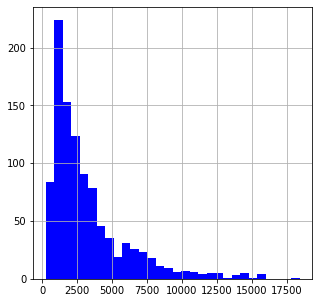

In [ ]:
# histogramme de la représentation
df['montant'].hist(bins = 30, figsize = (5,5), color = 'b')

Nous faisons une copie de notre df afin de garder un original.

In [ ]:
df_final = df.copy()

Visualisation corrélation entre features

No handles with labels found to put in legend.


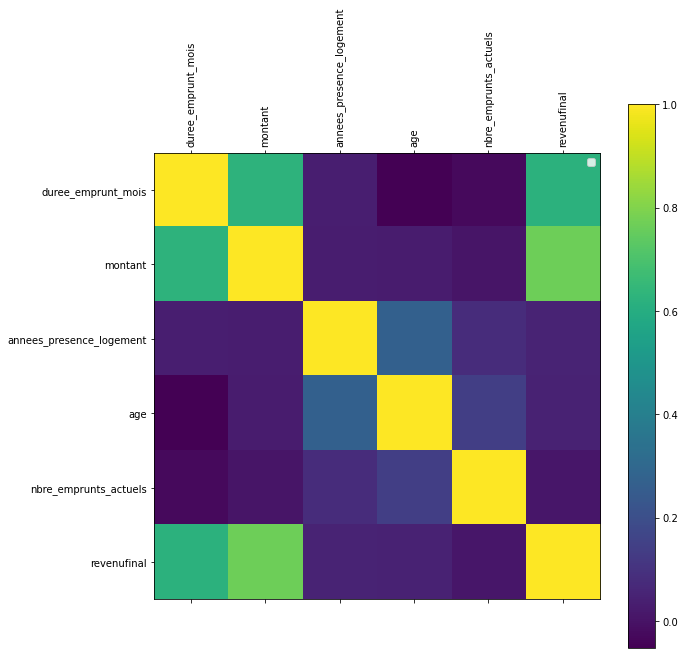

In [ ]:
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.legend()
    cax = ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
        
plot_corr(df_final)

In [ ]:
df_final.corr()

,duree_emprunt_mois,montant,annees_presence_logement,age,nbre_emprunts_actuels,revenufinal
duree_emprunt_mois,1.000000,0.627381,0.037141,-0.051893,-0.025859,0.622605
montant,0.627381,1.000000,0.032718,0.028819,0.009092,0.768976
annees_presence_logement,0.037141,0.032718,1.000000,0.269814,0.079822,0.054860
age,-0.051893,0.028819,0.269814,1.000000,0.142161,0.047762
nbre_emprunts_actuels,-0.025859,0.009092,0.079822,0.142161,1.000000,0.011515
revenufinal,0.622605,0.768976,0.054860,0.047762,0.011515,1.000000


##**Préparation data frame pour algo**

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   compte_courant            1021 non-null   object 
 1   duree_emprunt_mois        1021 non-null   int64  
 2   historique_credit         1021 non-null   object 
 3   raison                    1021 non-null   object 
 4   montant                   1021 non-null   int64  
 5   compte_epargne            1020 non-null   object 
 6   duree_emploi              1021 non-null   object 
 7   annees_presence_logement  1018 non-null   float64
 8   age                       1020 non-null   float64
 9   autre_credit              1021 non-null   object 
 10  logement                  1021 non-null   object 
 11  nbre_emprunts_actuels     1021 non-null   int64  
 12  job                       1018 non-null   object 
 13  dependants                1021 non-null   object 
 14  telephon

##**A-Traitement des valeurs manquantes**

In [ ]:
df_final.isnull().sum()

compte_courant              0
duree_emprunt_mois          0
historique_credit           0
raison                      0
montant                     0
compte_epargne              1
duree_emploi                0
annees_presence_logement    3
age                         1
autre_credit                0
logement                    0
nbre_emprunts_actuels       0
job                         3
dependants                  0
telephone                   0
defaillant                  1
revenufinal                 0
dtype: int64

In [ ]:
mask = False
for col in df_final.columns : mask = mask | df_final[col].isnull()
dfnulls = df_final[mask]

dfnulls 

,compte_courant,duree_emprunt_mois,historique_credit,raison,montant,compte_epargne,duree_emploi,annees_presence_logement,age,autre_credit,logement,nbre_emprunts_actuels,job,dependants,telephone,defaillant,revenufinal
29,inconnu,7,critique,ameublement,1280,< 100 Euro,> 7 annes,NaN,NaN,2,qualifie,1,oui,oui,oui,NaN,6584.168778
413,inconnu,15,bon,auto,1430,500 - 1000 Euro,> 7 annees,NaN,31.0,aucun,proprietaire,2,qualifie,2,oui,non,6493.120171
458,inconnu,10,pauvre,business,2440,NaN,4 - 7 annees,1.0,29.0,aucun,proprietaire,2,qualifie,1,oui,oui,3604.960438
709,1 - 200 Euro,18,pauvre,auto,6300,< 100 Euro,> 7 annees,NaN,42.0,aucun,autre,1,qualifie,1,oui,oui,31068.029379
826,1 - 200 Euro,8,bon,business,907,< 100 Euro,< 1 annee,2.0,26.0,aucun,proprietaire,1,NaN,1,oui,non,3070.511597
853,inconnu,4,bon,ameublement,601,< 100 Euro,< 1 annee,3.0,23.0,aucun,locataire,1,NaN,2,oui,non,1056.317863
858,inconnu,18,bon,renonvations,1943,< 100 Euro,< 1 annee,4.0,23.0,aucun,proprietaire,1,NaN,1,oui,oui,9862.654808


df_na uniquement les variables pour lesquelles il y a des valeurs manquantes

In [ ]:
df_na = (df_final.isnull().sum() / len(df_final)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)
missing_df = pd.DataFrame({'Ratio valeurs manquantes' : df_na})
missing_df

,Ratio valeurs manquantes
job,0.293830
annees_presence_logement,0.293830
defaillant,0.097943
age,0.097943
compte_epargne,0.097943


Aucune colonne a plus de 50% de données manquantes donc on ne retire pas de colonne.

**Données numériques on remplace par les valeurs médianes : annees_presence_logement, age**

In [ ]:
print(df_final['annees_presence_logement'].median())
df_final['annees_presence_logement'] = df_final['annees_presence_logement'].fillna(df_final['annees_presence_logement'].median()) 

print(df_final['age'].median())
df_final['age'] = df_final['age'].fillna(df_final['age'].median())

3.0
33.0


**Données catégorielles : job, defaillant, compte_epargne**

Pour la variable job on remplace les NA par la valeur en plus grand nombre, et le "Oui" on le met dans la classe de plus grand nombre aussi (car pas trop de sens )

In [ ]:
print(df_final['job'].value_counts())
# remplacement valeurs manquantes par le mode
df_final['job'].fillna('qualifie', inplace=True)
df_final['job']=df_final['job'].replace('oui', 'qualifie')

qualifie        648
non_qualifie    199
management      148
chomeur          22
oui               1
Name: job, dtype: int64


In [ ]:
print(df_final['defaillant'].value_counts())
# remplacement valeurs manquantes par le mode
df_final['defaillant'].fillna('non', inplace=True)

non    717
oui    303
Name: defaillant, dtype: int64


Défaillant - nombre de catégories : 2 - Pourcentage de la valeur non : 0.703232125367287


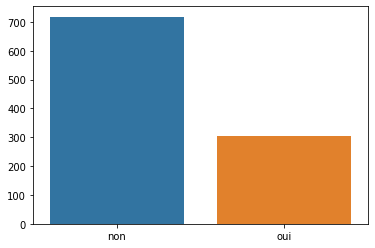

In [ ]:
# barplot pour variable nbre_portes
test = df_final.groupby(df_final['defaillant']).size().sort_values(ascending=False)
sns.barplot(x=list(test.index), y=list(test.iloc[0:]))
print('Défaillant' + ' - nombre de catégories : ' + str(len(test)) + ' - Pourcentage de la valeur non : ' + str(test[0]/len(df_final)))

In [ ]:
print(df_final['compte_epargne'].value_counts())
# remplacement valeurs manquantes par le mode
df_final['compte_epargne'].fillna('< 100 Euro', inplace=True)

< 100 Euro         611
inconnu            189
100 - 500 Euro     108
500 - 1000 Euro     64
> 1000 Euro         48
Name: compte_epargne, dtype: int64


In [ ]:
# vérification valeurs manquantes restantes après remplacement
df_final.isnull().sum()

compte_courant              0
duree_emprunt_mois          0
historique_credit           0
raison                      0
montant                     0
compte_epargne              0
duree_emploi                0
annees_presence_logement    0
age                         0
autre_credit                0
logement                    0
nbre_emprunts_actuels       0
job                         0
dependants                  0
telephone                   0
defaillant                  0
revenufinal                 0
dtype: int64

##**B-Traitement des outliers**

Les variables concernées.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


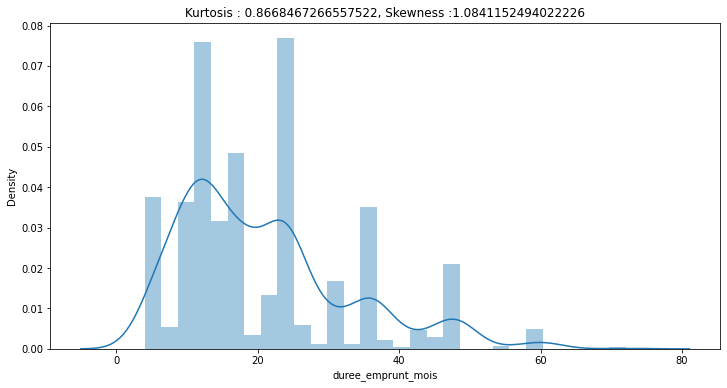

In [ ]:
# distribution de la variable duree_emprunt_mois et calculs kurtosis et skewness
plt.figure(figsize=(12,6))
sns.distplot(df['duree_emprunt_mois'].dropna())
plt.title('Kurtosis : ' +str(df['duree_emprunt_mois'].kurtosis())+ ', Skewness :' + str(df['duree_emprunt_mois'].skew()))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


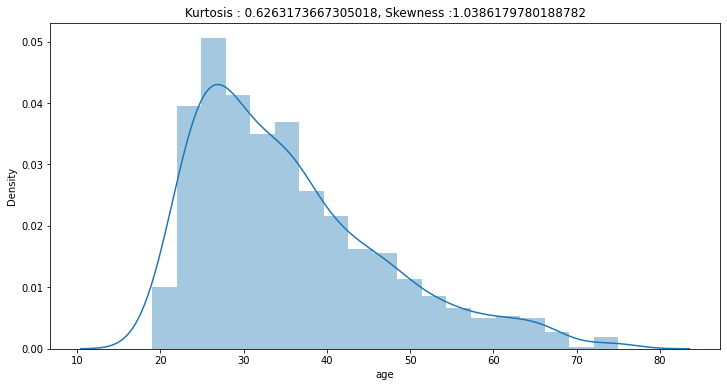

In [ ]:
# distribution de la variable age et calculs kurtosis et skewness
plt.figure(figsize=(12,6))
sns.distplot(df['age'].dropna())
plt.title('Kurtosis : ' +str(df['age'].kurtosis())+ ', Skewness :' + str(df['age'].skew()))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


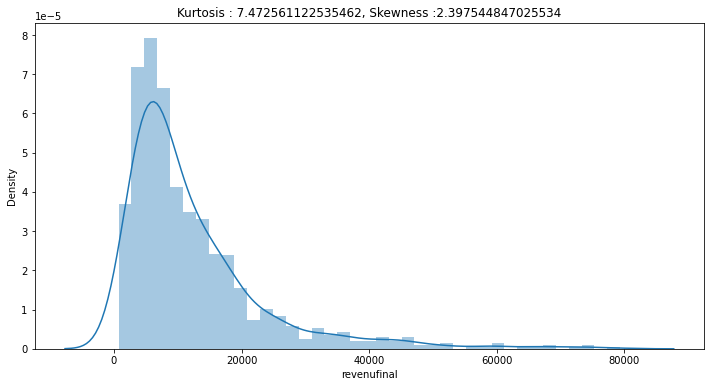

In [ ]:
# distribution de la variable revenufinal et calculs kurtosis et skewness
plt.figure(figsize=(12,6))
sns.distplot(df['revenufinal'].dropna())
plt.title('Kurtosis : ' +str(df['revenufinal'].kurtosis())+ ', Skewness :' + str(df['revenufinal'].skew()))
plt.show()

On ne remarque rien d'abérent pour les variables numériques. Pas de retraitement. 

##**C-Traitement des variables catégorielles**

['compte_courant', 'historique_credit', 'raison', 'compte_epargne', 'duree_emploi', 'autre_credit', 'logement', 'job', 'dependants', 'telephone', 'defaillant']
compte_courant - nombre de catégories : 4 - Pourcentage de la valeur 1 : 0.39373163565132224
historique_credit - nombre de catégories : 5 - Pourcentage de la valeur 1 : 0.5239960822722821
raison - nombre de catégories : 6 - Pourcentage de la valeur 1 : 0.47600391772771794
compte_epargne - nombre de catégories : 5 - Pourcentage de la valeur 1 : 0.5994123408423114
duree_emploi - nombre de catégories : 6 - Pourcentage de la valeur 1 : 0.3418217433888345
autre_credit - nombre de catégories : 4 - Pourcentage de la valeur 1 : 0.8168462291870715
logement - nombre de catégories : 4 - Pourcentage de la valeur 1 : 0.7159647404505387
job - nombre de catégories : 4 - Pourcentage de la valeur 1 : 0.6385896180215475
dependants - nombre de catégories : 3 - Pourcentage de la valeur 1 : 0.8462291870714985
telephone - nombre de catégories : 1 - P

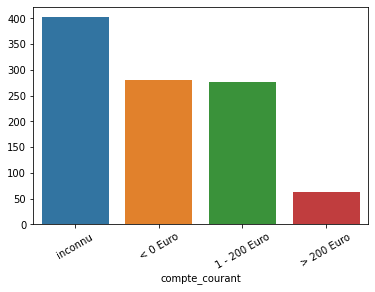

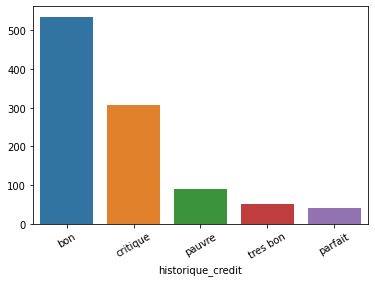

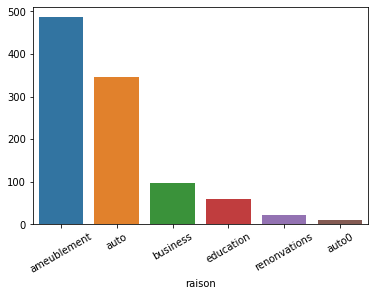

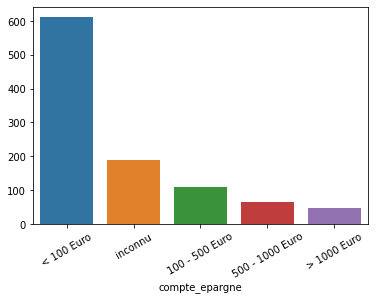

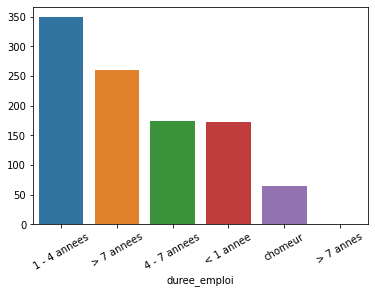

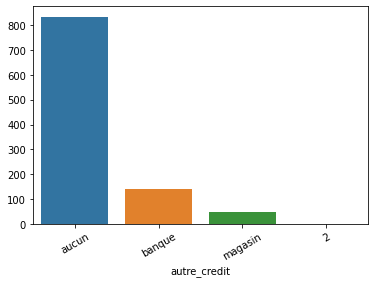

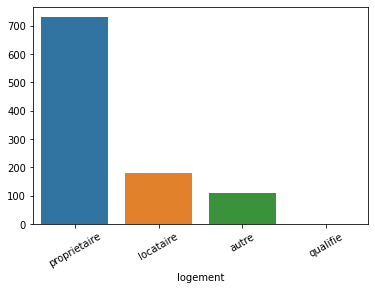

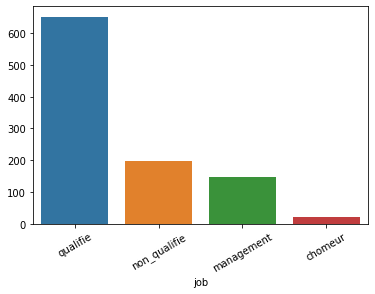

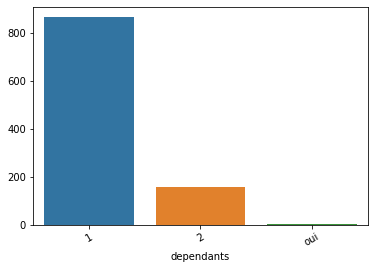

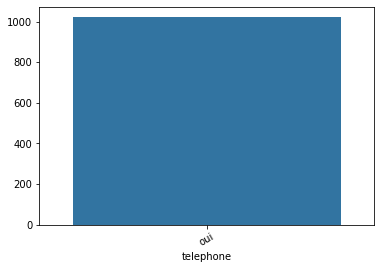

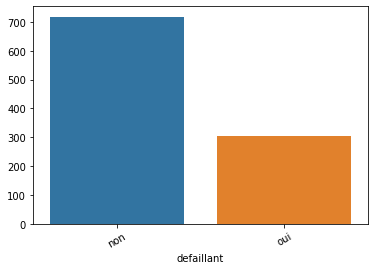

In [ ]:
# liste de toutes les variables catégorielles
allcatColumns = list(df_final.select_dtypes(include=['object']).columns)
print(allcatColumns)

#barplot pour variable 
def barplot(variable1):
  test = df_final.groupby(df_final[variable1]).size().sort_values(ascending=False)
  ax = sns.barplot(x=list(test.index), y=list(test.iloc[0:]))
  ax.set(xlabel=variable1)
  print(variable1 + ' - nombre de catégories : ' + str(len(test)) + ' - Pourcentage de la valeur 1 : ' + str(test[0]/len(df_final)))
  

#affiche les barplot pour chaque variable 
for var in allcatColumns:
  plt.figure()
  barplot(var)
  plt.xticks(rotation=30)

on peut supprimer la variable dépendant >80% et telephone 100%

In [ ]:
del df_final["dependants"]
del df_final["telephone"]

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   compte_courant            1021 non-null   object 
 1   duree_emprunt_mois        1021 non-null   int64  
 2   historique_credit         1021 non-null   object 
 3   raison                    1021 non-null   object 
 4   montant                   1021 non-null   int64  
 5   compte_epargne            1021 non-null   object 
 6   duree_emploi              1021 non-null   object 
 7   annees_presence_logement  1021 non-null   float64
 8   age                       1021 non-null   float64
 9   autre_credit              1021 non-null   object 
 10  logement                  1021 non-null   object 
 11  nbre_emprunts_actuels     1021 non-null   int64  
 12  job                       1021 non-null   object 
 13  defaillant                1021 non-null   object 
 14  revenufi

In [ ]:
# Transformation variables catégorielles avec One Hot Encoding
categorial = ['compte_courant', 'historique_credit', 'raison', 'compte_epargne', 'duree_emploi', 'autre_credit', 'logement', 'job', 'defaillant']
df_final = pd.get_dummies(df_final, columns=categorial, drop_first=True)
df_final.head()

,duree_emprunt_mois,montant,annees_presence_logement,age,nbre_emprunts_actuels,revenufinal,compte_courant_< 0 Euro,compte_courant_> 200 Euro,compte_courant_inconnu,historique_credit_critique,historique_credit_parfait,historique_credit_pauvre,historique_credit_tres bon,raison_auto,raison_auto0,raison_business,raison_education,raison_renonvations,compte_epargne_500 - 1000 Euro,compte_epargne_< 100 Euro,compte_epargne_> 1000 Euro,compte_epargne_inconnu,duree_emploi_4 - 7 annees,duree_emploi_< 1 annee,duree_emploi_> 7 annees,duree_emploi_> 7 annes,duree_emploi_chomeur,autre_credit_aucun,autre_credit_banque,autre_credit_magasin,logement_locataire,logement_proprietaire,logement_qualifie,job_management,job_non_qualifie,job_qualifie,defaillant_oui
0,6,1169,4.0,67.0,2,8135.110140,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0
1,48,5951,2.0,22.0,1,19334.307686,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1
2,12,2096,3.0,49.0,1,4864.954258,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
3,42,7882,4.0,45.0,1,22152.947349,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,24,4870,4.0,53.0,2,23900.704144,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1


In [ ]:
# Nombre de features en final
len(df_final.columns)

37

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   duree_emprunt_mois              1021 non-null   int64  
 1   montant                         1021 non-null   int64  
 2   annees_presence_logement        1021 non-null   float64
 3   age                             1021 non-null   float64
 4   nbre_emprunts_actuels           1021 non-null   int64  
 5   revenufinal                     1021 non-null   float64
 6   compte_courant_< 0 Euro         1021 non-null   uint8  
 7   compte_courant_> 200 Euro       1021 non-null   uint8  
 8   compte_courant_inconnu          1021 non-null   uint8  
 9   historique_credit_critique      1021 non-null   uint8  
 10  historique_credit_parfait       1021 non-null   uint8  
 11  historique_credit_pauvre        1021 non-null   uint8  
 12  historique_credit_tres bon      10

In [ ]:
# Suppression de la variable montant dans X et transformation en array avec values
X = df_final.drop(['montant'],axis=1).values

# Label Fidelite dans y 
y = df_final['montant'].values

# **2- Modélisation : Montant du prêt fonction des features :**

**Réseau de neurones ANN**

## **A- Découpe du data set en train data set et test data set (30 % des données)**

In [ ]:
# Split it train set et test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

In [ ]:
sc = StandardScaler()
# fit transform sur le train set et transform uniquement sur test set
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# transformation en data frame de X_train
df_train = pd.DataFrame(X_train)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,0.032824,1.055942,-1.060424,-0.718823,0.378623,-0.634626,-0.246822,1.252336,1.488696,-0.194398,-0.319142,-0.213045,-0.693778,-0.106449,-0.334887,-0.253147,-0.156174,-0.274411,0.841507,-0.223607,-0.480660,-0.451716,2.258886,-0.580585,-0.03745,-0.271448,0.46291,-0.389375,-0.213045,-0.462910,0.628117,-0.03745,-0.415227,-0.485071,0.75219,-0.652035
1,-0.715147,-1.633508,-1.146492,-0.718823,-0.251987,1.575731,-0.246822,-0.798508,-0.671729,-0.194398,-0.319142,-0.213045,-0.693778,-0.106449,-0.334887,-0.253147,-0.156174,-0.274411,0.841507,-0.223607,-0.480660,-0.451716,2.258886,-0.580585,-0.03745,-0.271448,0.46291,-0.389375,-0.213045,2.160247,-1.592060,-0.03745,-0.415227,-0.485071,0.75219,-0.652035
2,0.282148,1.055942,1.607693,0.991976,-0.737474,-0.634626,-0.246822,1.252336,-0.671729,-0.194398,3.133398,-0.213045,1.441383,-0.106449,-0.334887,-0.253147,-0.156174,-0.274411,-1.188344,-0.223607,2.080471,-0.451716,-0.442696,1.722401,-0.03745,-0.271448,0.46291,-0.389375,-0.213045,-0.462910,0.628117,-0.03745,-0.415227,-0.485071,0.75219,-0.652035
3,0.282148,0.159459,-0.371878,-0.718823,-0.078969,1.575731,-0.246822,-0.798508,-0.671729,-0.194398,-0.319142,-0.213045,1.441383,-0.106449,-0.334887,-0.253147,-0.156174,-0.274411,0.841507,-0.223607,-0.480660,2.213781,-0.442696,-0.580585,-0.03745,-0.271448,0.46291,-0.389375,-0.213045,-0.462910,0.628117,-0.03745,-0.415227,-0.485071,0.75219,1.533660
4,-0.964470,-0.737025,0.058464,0.991976,-0.480475,1.575731,-0.246822,-0.798508,1.488696,-0.194398,-0.319142,-0.213045,1.441383,-0.106449,-0.334887,-0.253147,-0.156174,-0.274411,0.841507,-0.223607,-0.480660,-0.451716,-0.442696,-0.580585,-0.03745,-0.271448,0.46291,-0.389375,-0.213045,2.160247,-1.592060,-0.03745,-0.415227,-0.485071,0.75219,-0.652035


In [ ]:
df_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
count,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02
mean,-5.963173e-17,-1.792839e-16,2.256210e-16,2.064953e-16,-1.011174e-15,-7.899066e-17,-1.749301e-17,-7.183796e-17,-3.094319e-17,9.073041e-17,-6.079793e-17,4.179663e-16,4.574616e-16,2.491393e-16,-1.422765e-16,-2.010530e-16,8.730956e-17,-7.230444e-17,-1.523836e-17,-3.012685e-16,-6.048694e-17,2.368165e-16,5.450044e-17,-1.903239e-16,-3.312399e-16,1.752411e-16,1.306145e-16,-3.047671e-17,3.927764e-16,-1.104003e-17,-1.371452e-16,-3.312399e-16,-9.811635e-17,-1.811498e-17,1.691768e-16,-2.052513e-17
std,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00,1.000701e+00
min,-1.380010e+00,-1.633508e+00,-1.404697e+00,-7.188232e-01,-1.060173e+00,-6.346263e-01,-2.468223e-01,-7.985078e-01,-6.717287e-01,-1.943983e-01,-3.191424e-01,-2.130446e-01,-6.937779e-01,-1.064493e-01,-3.348873e-01,-2.531471e-01,-1.561738e-01,-2.744106e-01,-1.188344e+00,-2.236068e-01,-4.806605e-01,-4.517159e-01,-4.426962e-01,-5.805847e-01,-3.745029e-02,-2.714484e-01,-2.160247e+00,-3.893750e-01,-2.130446e-01,-4.629100e-01,-1.592060e+00,-3.745029e-02,-4.152274e-01,-4.850713e-01,-1.329452e+00,-6.520350e-01
25%,-7.151467e-01,-7.370249e-01,-8.022191e-01,-7.188232e-01,-6.382143e-01,-6.346263e-01,-2.468223e-01,-7.985078e-01,-6.717287e-01,-1.943983e-01,-3.191424e-01,-2.130446e-01,-6.937779e-01,-1.064493e-01,-3.348873e-01,-2.531471e-01,-1.561738e-01,-2.744106e-01,-1.188344e+00,-2.236068e-01,-4.806605e-01,-4.517159e-01,-4.426962e-01,-5.805847e-01,-3.745029e-02,-2.714484e-01,4.629100e-01,-3.893750e-01,-2.130446e-01,-4.629100e-01,-1.592060e+00,-3.745029e-02,-4.152274e-01,-4.850713e-01,-1.329452e+00,-6.520350e-01
50%,-2.164995e-01,1.594585e-01,-2.427752e-01,-7.188232e-01,-3.241650e-01,-6.346263e-01,-2.468223e-01,-7.985078e-01,-6.717287e-01,-1.943983e-01,-3.191424e-01,-2.130446e-01,-6.937779e-01,-1.064493e-01,-3.348873e-01,-2.531471e-01,-1.561738e-01,-2.744106e-01,8.415070e-01,-2.236068e-01,-4.806605e-01,-4.517159e-01,-4.426962e-01,-5.805847e-01,-3.745029e-02,-2.714484e-01,4.629100e-01,-3.893750e-01,-2.130446e-01,-4.629100e-01,6.281172e-01,-3.745029e-02,-4.152274e-01,-4.850713e-01,7.521898e-01,-6.520350e-01
75%,2.821477e-01,1.055942e+00,4.888052e-01,9.919761e-01,2.884924e-01,1.575731e+00,-2.468223e-01,1.252336e+00,1.488696e+00,-1.943983e-01,-3.191424e-01,-2.130446e-01,1.441383e+00,-1.064493e-01,-3.348873e-01,-2.531471e-01,-1.561738e-01,-2.744106e-01,8.415070e-01,-2.236068e-01,-4.806605e-01,-4.517159e-01,-4.426962e-01,1.722401e+00,-3.745029e-02,-2.714484e-01,4.629100e-01,-3.893750e-01,-2.130446e-01,-4.629100e-01,6.281172e-01,-3.745029e-02,-4.152274e-01,-4.850713e-01,7.521898e-01,1.533660e+00
max,4.271325e+00,1.055942e+00,3.415127e+00,4.413575e+00,5.765948e+00,1.575731e+00,4.051498e+00,1.252336e+00,1.488696e+00,5.144078e+00,3.133398e+00,4.693853e+00,1.441383e+00,9.394147e+00,2.986079e+00,3.950272e+00,6.403124e+00,3.644173e+00,8.415070e-01,4.472136e+00,2.080471e+00,2.213781e+00,2.258886e+00,1.722401e+00,2.670206e+01,3.683942e+00,4.629100e-01,2.568218e+00,4.693853e+00,2.160247e+00,6.281172e-01,2.670206e+01,2.408319e+00,2.061553e+00,7.

## **2-1 - Dans un premier temps, construire un modèle avec une seule couche cachée, la couche d’entrée et la couche cachée ayant chacune 60 neurones**
Choisir les valeurs des hyperparamètres suivantes :

Optimizer : Adam

Loss : mean_squared_error

Nombre d’époques : 50 

Batch_size : 25 

Validation_split : 20%

**Modèle avec couches cachées (deep learning) et drop out pour réduite l'overfitting : désactivation aléatoire d'un % de neurones**

In [ ]:
model2 = Sequential()
# couches avec nbre de neurones 60, puis 60 
# ajout Dropout après chaque couche Dense
# Couche d'entrée


model2.add(Dense(60, activation='relu', input_dim=36))
model2.add(Dropout(0.2, noise_shape=None, seed=None))

# Hidden Layer 1
model2.add(Dense(60, activation='relu'))
model2.add(Dropout(0.2, noise_shape=None, seed=None))

model2.add(Dense(1, activation='relu'))

model2.summary()

Model: "sequential_246"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_984 (Dense)            (None, 60)                2220      
_________________________________________________________________
dropout_12 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_985 (Dense)            (None, 60)                3660      
_________________________________________________________________
dropout_13 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_986 (Dense)            (None, 1)                 61        
Total params: 5,941
Trainable params: 5,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])

In [ ]:
# training du modèle
batch_size = 25
epochs = 50

history = model2.fit(X_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_test, y_test))

score = model2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test mse:', score[1])

Epoch 1/50
29/29 [==============================] - 1s 8ms/step - loss: 19046376.8667 - mse: 19046377.0000 - val_loss: 20363444.0000 - val_mse: 20363444.0000
Epoch 2/50
29/29 [==============================] - 0s 3ms/step - loss: 19142958.6000 - mse: 19142958.6000 - val_loss: 20314638.0000 - val_mse: 20314638.0000
Epoch 3/50
29/29 [==============================] - 0s 3ms/step - loss: 15100369.3500 - mse: 15100369.3500 - val_loss: 20217892.0000 - val_mse: 20217892.0000
Epoch 4/50
29/29 [==============================] - 0s 3ms/step - loss: 18807148.2000 - mse: 18807148.2000 - val_loss: 20046472.0000 - val_mse: 20046470.0000
Epoch 5/50
29/29 [==============================] - 0s 3ms/step - loss: 16431382.8000 - mse: 16431382.8000 - val_loss: 19768888.0000 - val_mse: 19768888.0000
Epoch 6/50
29/29 [==============================] - 0s 3ms/step - loss: 17252959.7333 - mse: 17252959.7333 - val_loss: 19340278.0000 - val_mse: 19340278.0000
Epoch 7/50
29/29 [==============================] - 

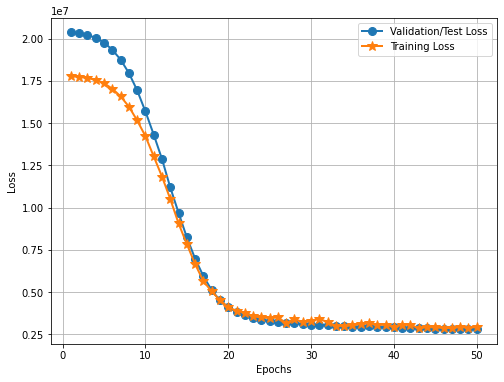

In [ ]:
# Plot des loss 

plt.figure(figsize=(8,6))
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = 'o', markersize=8.0)
plt.setp(line2, linewidth=2.0, marker = '*', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Déterminons le R2

In [ ]:
ypredict_train = model2.predict(X_train, verbose=0)
ypredict_test = model2.predict(X_test, verbose=0)

In [ ]:
r2_train=r2_score(y_train, ypredict_train)
r2_test=r2_score(y_test, ypredict_test)
print(r2_train)
print(r2_test)

0.6471225096274202
0.6844535302031209


Le modèle prédit pas trop mal comme le montrent les résultats de la loss et du R2. Nous allons optimiser les hyperparamètres de notre réseau de neurones.

## **2-2 - Amélioration modèle initial suggéré par l'énoncé**

---



In [ ]:
def build_regressor2(optimizer='adam'):
    classifier = Sequential()
    classifier.add(Dense(units = 60, kernel_initializer = 'uniform', activation = 'relu', input_dim = 36))
    classifier.add(Dense(units = 60, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mse'])
    return classifier

In [ ]:
# choix des hyperparamètres optimaux avec grid Search
from sklearn.model_selection import GridSearchCV

classifier = KerasRegressor(build_fn = build_regressor2)

# hyperparametres à mettre dans un dictionnaire
parameters = {'batch_size': [16, 32, 40, 64],
              'epochs': [10, 60, 100],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 5)
# entrainement 
grid_search = grid_search.fit(X_train, y_train)
# meilleurs résultats 
best_parameters = grid_search.best_params_
best_mse = grid_search.best_score_

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
15/15 [==============================] - 0s 2ms/step - loss: 15242967.6250 - mse: 15242967.6250
Epoch 15/100
15/15 [==============================] - 0s 2ms/step - loss: 14228439.8125 - mse: 14228439.8125
Epoch 16/100
15/15 [==============================] - 0s 2ms/step - loss: 12506689.8750 - mse: 12506689.8750
Epoch 17/100
15/15 [==============================] - 0s 2ms/step - loss: 13527985.5625 - mse: 13527985.5625
Epoch 18/100
15/15 [==============================] - 0s 2ms/step - loss: 12473477.1250 - mse: 12473477.1250
Epoch 19/100
15/15 [==============================] - 0s 2ms/step - loss: 12462395.6250 - mse: 12462395.6250
Epoch 20/100
15/15 [==============================] - 0s 3ms/step - loss: 10570983.8750 - mse: 10570983.8750
Epoch 21/100
15/15 [==============================] - 0s 2ms/step - loss: 10309677.1875 - mse: 10309677.1875
Epoch 22/100
15/15 [==============================] - 0s 2ms/st

In [ ]:
print(best_parameters)

{'batch_size': 16, 'epochs': 100, 'optimizer': 'adam'}


In [ ]:
print(best_mse)

-3287323.812939548


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
model3 = Sequential()
# couches avec nbre de neurones 60, puis 60 
# ajout Dropout après chaque couche Dense
# Couche d'entrée


model3.add(Dense(60, activation='relu', input_dim=36))
model3.add(Dropout(0.2, noise_shape=None, seed=None))

# Hidden Layer 1
model3.add(Dense(60, activation='relu'))
model3.add(Dropout(0.2, noise_shape=None, seed=None))

model3.add(Dense(1, activation='relu'))

model3.summary()

Model: "sequential_368"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1350 (Dense)           (None, 60)                2220      
_________________________________________________________________
dropout_14 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_1351 (Dense)           (None, 60)                3660      
_________________________________________________________________
dropout_15 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_1352 (Dense)           (None, 1)                 61        
Total params: 5,941
Trainable params: 5,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
# training du modèle
batch_size = 16
epochs = 100

history3 = model3.fit(X_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_test, y_test))

score3 = model3.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot des loss 

plt.figure(figsize=(8,6))
history_dict3 = history3.history

Epoch 1/100
45/45 [==============================] - 1s 9ms/step - loss: 18521553.3043 - mse: 18521553.3043 - val_loss: 20359552.0000 - val_mse: 20359552.0000
Epoch 2/100
45/45 [==============================] - 0s 4ms/step - loss: 17455153.9783 - mse: 17455153.9783 - val_loss: 20258970.0000 - val_mse: 20258970.0000
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 18000489.4565 - mse: 18000489.4565 - val_loss: 20008716.0000 - val_mse: 20008716.0000
Epoch 4/100
45/45 [==============================] - 0s 4ms/step - loss: 16484295.6739 - mse: 16484295.6739 - val_loss: 19510318.0000 - val_mse: 19510318.0000
Epoch 5/100
45/45 [==============================] - 0s 4ms/step - loss: 17232468.8913 - mse: 17232468.8913 - val_loss: 18646794.0000 - val_mse: 18646794.0000
Epoch 6/100
45/45 [==============================] - 0s 4ms/step - loss: 16280121.2391 - mse: 16280121.2391 - val_loss: 17313376.0000 - val_mse: 17313376.0000
Epoch 7/100
45/45 [===========================

<Figure size 576x432 with 0 Axes>

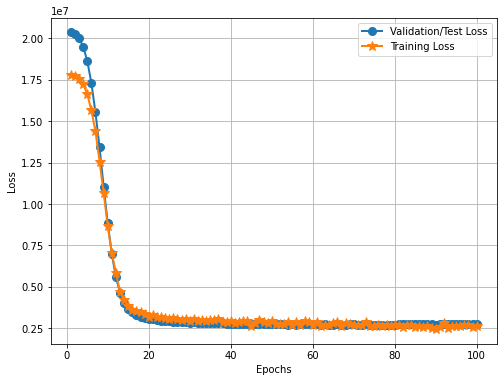

In [ ]:
# Plot des loss 
plt.figure(figsize=(8,6))
history_dict = history3.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = 'o', markersize=8.0)
plt.setp(line2, linewidth=2.0, marker = '*', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
ypredict_train3 = model3.predict(X_train, verbose=0)
ypredict_test3 = model3.predict(X_test, verbose=0)

In [ ]:
r2_train=r2_score(y_train, ypredict_train3)
r2_test=r2_score(y_test, ypredict_test3)
print(r2_train)
print(r2_test)

0.6909545972031617
0.6918420376606667


## **Notre modèle**

In [ ]:
from tensorflow.keras.layers import Dropout

model3 = Sequential()
# couches avec nbre de neurones 22, puis 11 puis 11
# ajout Dropout après chaque couche Dense
# Couche d'entrée
model3.add(Dense(90, activation='elu', input_dim=36))
model3.add(Dropout(0.1, noise_shape=None, seed=None))

# Hidden Layer 1
model3.add(Dense(90, activation='elu'))
model3.add(Dropout(0.1, noise_shape=None, seed=None))

# Hidden Layer 2
model3.add(Dense(60, activation = 'elu'))
model3.add(Dropout(0.1, noise_shape=None, seed=None))

# Hidden Layer 3
model3.add(Dense(60, activation = 'elu'))
model3.add(Dropout(0.1, noise_shape=None, seed=None))



model3.add(Dense(1, activation='relu'))

model3.summary()


Model: "sequential_492"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1968 (Dense)           (None, 90)                3330      
_________________________________________________________________
dropout_24 (Dropout)         (None, 90)                0         
_________________________________________________________________
dense_1969 (Dense)           (None, 90)                8190      
_________________________________________________________________
dropout_25 (Dropout)         (None, 90)                0         
_________________________________________________________________
dense_1970 (Dense)           (None, 60)                5460      
_________________________________________________________________
dropout_26 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_1971 (Dense)           (None, 60)             

In [ ]:
model3.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
# training du modèle
batch_size = 40
epochs = 60

history3 = model3.fit(X_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_test, y_test))

score3 = model3.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot des loss 

plt.figure(figsize=(8,6))
history_dict3 = history3.history



NameError: ignored

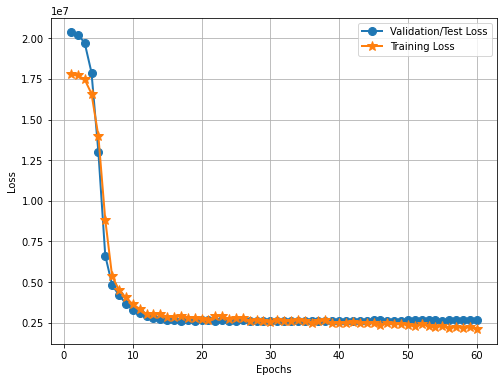

In [ ]:
# Plot des loss 

plt.figure(figsize=(8,6))
history_dict3 = history3.history

loss_values3 = history_dict3['loss']
val_loss_values3 = history_dict3['val_loss']
epochs3 = range(1, len(loss_values3) + 1)
line1 = plt.plot(epochs3, val_loss_values3, label='Validation/Test Loss')
line2 = plt.plot(epochs3, loss_values3, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = 'o', markersize=8.0)
plt.setp(line2, linewidth=2.0, marker = '*', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
ypredict_train3 = model3.predict(X_train, verbose=0)
ypredict_test3 = model3.predict(X_test, verbose=0)

In [ ]:
r2_train=r2_score(y_train, ypredict_train3)
r2_test=r2_score(y_test, ypredict_test3)
print(r2_train)
print(r2_test)

0.7518130620083894
0.6991061794847603


Nous avons amélioré notre R2. Essayons de l'améliorer encore en déterminant les paramètres optimaux à l'aide d'une GridSearch.

**Optimisation de notre modèle**

In [ ]:
def build_regressor(optimizer='adam'):
    classifier = Sequential()
    classifier.add(Dense(units = 90, kernel_initializer = 'uniform', activation = 'elu', input_dim = 36))
    classifier.add(Dense(units = 90, kernel_initializer = 'uniform', activation = 'elu'))
    classifier.add(Dense(units = 60, kernel_initializer = 'uniform', activation = 'elu'))
    classifier.add(Dense(units = 60, kernel_initializer = 'uniform', activation = 'elu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mse'])
    return classifier

In [ ]:
# choix des hyperparamètres optimaux avec grid Search
from sklearn.model_selection import GridSearchCV

classifier = KerasRegressor(build_fn = build_regressor)

# hyperparametres à mettre dans un dictionnaire
parameters = {'batch_size': [16, 32, 40, 64],
              'epochs': [10, 60, 100],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 5)
# entrainement 
grid_search = grid_search.fit(X_train, y_train)
# meilleurs résultats 
best_parameters = grid_search.best_params_
best_mse = grid_search.best_score_

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
15/15 [==============================] - 0s 4ms/step - loss: 2924129.4062 - mse: 2924129.4062
Epoch 75/100
15/15 [==============================] - 0s 4ms/step - loss: 2366440.3984 - mse: 2366440.5859
Epoch 76/100
15/15 [==============================] - 0s 4ms/step - loss: 2397434.8672 - mse: 2397434.8438
Epoch 77/100
15/15 [==============================] - 0s 6ms/step - loss: 2272682.8359 - mse: 2272682.8359
Epoch 78/100
15/15 [==============================] - 0s 5ms/step - loss: 2102644.8906 - mse: 2102644.8906
Epoch 79/100
15/15 [==============================] - 0s 6ms/step - loss: 2233053.8125 - mse: 2233053.8125
Epoch 80/100
15/15 [==============================] - 0s 6ms/step - loss: 2210374.4062 - mse: 2210374.4062
Epoch 81/100
15/15 [==============================] - 0s 4ms/step - loss: 2466668.0234 - mse: 2466668.0234
Epoch 82/100
15/15 [==============================] - 0s 3ms/step - loss: 23840

In [ ]:
# hyperparamètres optimaux
print(best_parameters)

{'batch_size': 64, 'epochs': 60, 'optimizer': 'rmsprop'}


In [ ]:
print(best_mse)

-3391022.6937006055


On a déterminé nos hyperparamètres optimaux.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
model4 = Sequential()
# couches avec nbre de neurones 90, puis 90 puis 60, puis 60
# ajout Dropout après chaque couche Dense
# Couche d'entrée
model4.add(Dense(90, activation='elu', input_dim=36))
model4.add(Dropout(0.1, noise_shape=None, seed=None))

# Hidden Layer 1
model4.add(Dense(90, activation='elu'))
model4.add(Dropout(0.1, noise_shape=None, seed=None))

# Hidden Layer 2
model4.add(Dense(60, activation = 'elu'))
model4.add(Dropout(0.1, noise_shape=None, seed=None))

# Hidden Layer 3
model4.add(Dense(60, activation = 'elu'))
model4.add(Dropout(0.1, noise_shape=None, seed=None))

model4.add(Dense(1, activation='relu'))

model4.summary()

Model: "sequential_614"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2578 (Dense)           (None, 90)                3330      
_________________________________________________________________
dropout_28 (Dropout)         (None, 90)                0         
_________________________________________________________________
dense_2579 (Dense)           (None, 90)                8190      
_________________________________________________________________
dropout_29 (Dropout)         (None, 90)                0         
_________________________________________________________________
dense_2580 (Dense)           (None, 60)                5460      
_________________________________________________________________
dropout_30 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_2581 (Dense)           (None, 60)             

In [ ]:
model4.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])

In [ ]:
# avec batch_size optimisé  
batch_size = 64
epochs = 60

history4 = model4.fit(X_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    callbacks=[early_stop],
                    validation_data = (X_test, y_test))

score = model4.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/60
12/12 [==============================] - 1s 22ms/step - loss: 16528991.9231 - mse: 16528991.9231 - val_loss: 20329462.0000 - val_mse: 20329462.0000
Epoch 2/60
12/12 [==============================] - 0s 6ms/step - loss: 18736374.6154 - mse: 18736374.6154 - val_loss: 20189416.0000 - val_mse: 20189416.0000
Epoch 3/60
12/12 [==============================] - 0s 8ms/step - loss: 18566043.3846 - mse: 18566043.3846 - val_loss: 19906726.0000 - val_mse: 19906726.0000
Epoch 4/60
12/12 [==============================] - 0s 8ms/step - loss: 17560916.0000 - mse: 17560916.0000 - val_loss: 19313466.0000 - val_mse: 19313466.0000
Epoch 5/60
12/12 [==============================] - 0s 8ms/step - loss: 16720706.2308 - mse: 16720706.2308 - val_loss: 18366262.0000 - val_mse: 18366262.0000
Epoch 6/60
12/12 [==============================] - 0s 9ms/step - loss: 15070087.2308 - mse: 15070087.2308 - val_loss: 16876816.0000 - val_mse: 16876816.0000
Epoch 7/60
12/12 [==============================] -

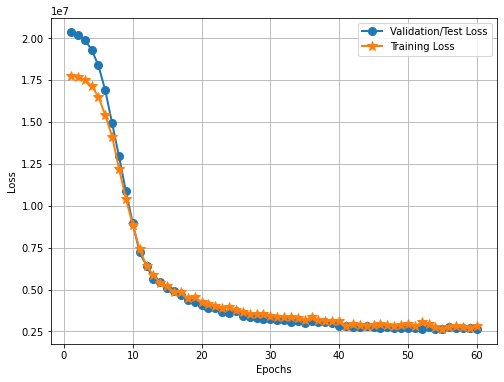

In [ ]:
# Plot des loss 
plt.figure(figsize=(8,6))
history_dict = history4.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = 'o', markersize=8.0)
plt.setp(line2, linewidth=2.0, marker = '*', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
ypredict_train4 = model4.predict(X_train, verbose=0)
ypredict_test4 = model4.predict(X_test, verbose=0)

In [ ]:
r2_train=r2_score(y_train, ypredict_train4)
r2_test=r2_score(y_test, ypredict_test4)
print(r2_train)
print(r2_test)

0.6704299817285788
0.7028285560100036
